<a href="https://colab.research.google.com/github/mashdas/time_series/blob/master/same_datat_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda x:x.batch(window_size+1))
  dataset=dataset.shuffle(shuffle_buffer).map(lambda x: (x[:-1],x[-1]))
  dataset=dataset.batch(batch_size).prefetch(1)##Batch_size here refers to the number of time stamps
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

from tensorflow.keras.layers import Bidirectional,LSTM,Dense,Lambda
from tensorflow.keras.models import Sequential
dataset=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

model=Sequential()

model.add(Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]))
##Time-series ip_format=window_size*time_stamps*dimensonality
model.add(Bidirectional(LSTM(32,return_sequences=True)))

model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))
model.add(Lambda(lambda x:x*100))


In [0]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8*10**(epoch/20))
optimizer=tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])


In [7]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [8]:
history=model.fit(dataset,epochs=100,callbacks=[lr_schedule])

















Epoch 1/100
31/31 [==============================] - 0s 10ms/step - loss: 63.4945 - mae: 63.9942 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 62.7415 - mae: 63.2413 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 61.8266 - mae: 62.3266 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 60.7968 - mae: 61.2968 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 59.6408 - mae: 60.1408 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 58.3369 - mae: 58.8369 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 56.8731 - mae: 57.3731 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 55.2292 - mae: 55.7291 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 53.3771 - mae: 53.8768

(1e-08, 0.0001, 0.0, 30.0)

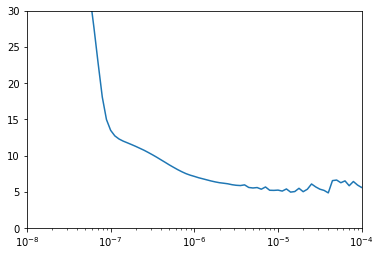

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
##From the plot,pick the best lr and retrain the model for more epochs
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

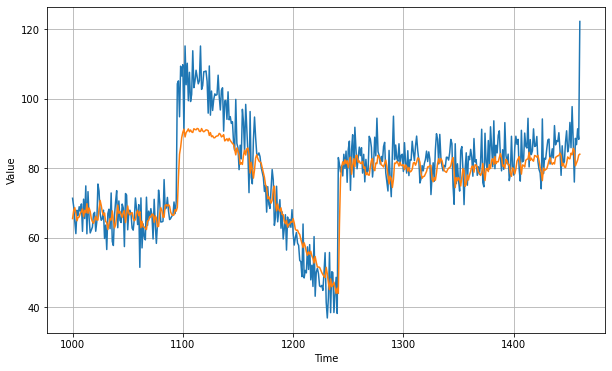

In [11]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.8554444

<Figure size 432x288 with 0 Axes>

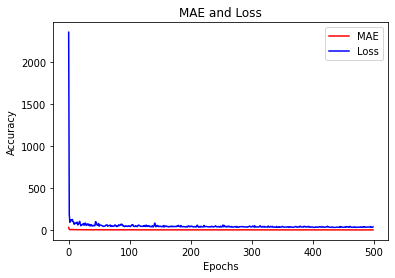

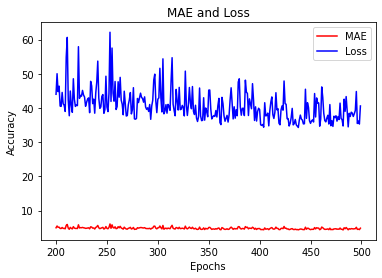

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()